In [1]:
import os 
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from gitstats import NWBGitInfo, GitHubRepoInfo

In [2]:
import git
import requests
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [3]:
git_repo_infos = NWBGitInfo.GIT_REPOS.get_info_objects()

# Plot the release timeline

In [4]:
# Define basic settings for the plot
# Plot results for select repos
select_repos = ['PyNWB', 'HDMF', 'MatNWB', 'NWB_Schema', 'HDMF_Common_Schema']
fontsize = 16
# Define additional releases to add to the timeline for select repos, e.g., if GitHub tags are missing for releases
# This is a dict where the keys are a subset of select_repos and the values are lists of tuples with the form
# (release: str, data: datetime)
additional_releases = { # Add 2.0 release for NWB schema using the same data as for PyNWB 1.0
                        # Add 2.0beta release for NWB schema using the same data for PyNWB 0.2.0
                        "NWB_Schema" : [("2.0.0", datetime.strptime("2019-01-19", "%Y-%m-%d")), 
                                       ("2.0.0b", datetime.strptime("2017-11-11", "%Y-%m-%d"))],
                        # Add first beta release for MatNWB using the same date as for PyNWB 0.2.0
                        "MatNWB" : [("0.1.0b", datetime.strptime("2017-11-11", "%Y-%m-%d"))] }
# Title for the plot
plot_title = "Timeline of NWB Release"
# Datetime range and step-size in month to use along the xaxis of the plot(s)
plot_xlim= (datetime.strptime("2017-09-15", "%Y-%m-%d"), 
            datetime.strptime("2022-08-17", "%Y-%m-%d"))
month_intervals = 2 

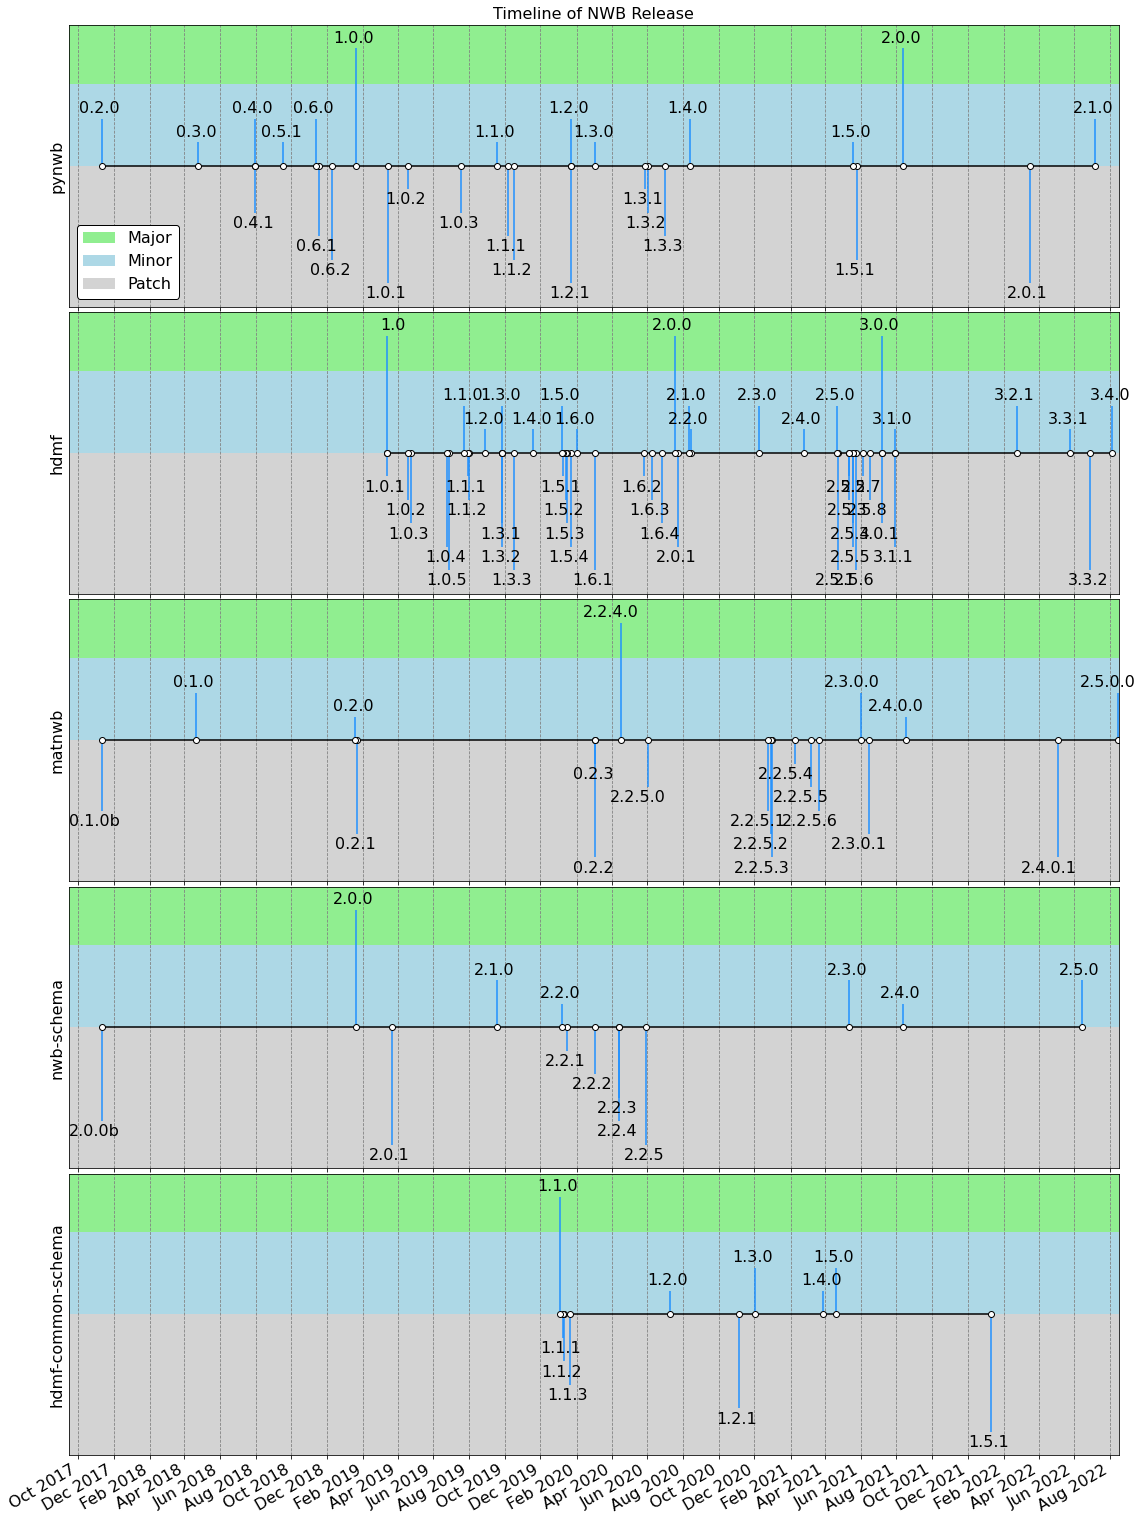

In [5]:
# Render the release timeline for all repos
fig, axes = plt.subplots(figsize=(16, len(select_repos)*4.2), 
                         nrows=len(select_repos), 
                         ncols=1, sharex=True, sharey=False, squeeze=True)
for i, repo in enumerate(select_repos):
    add_releases = additional_releases.get(repo, None)
    ax = git_repo_infos[repo].plot_release_timeline(
        fontsize=fontsize, 
        month_intervals=month_intervals,
        xlim=plot_xlim,
        ax=axes[i],
        title_on_yaxis=True,
        add_releases=add_releases)
    # Show the legend only on the first plot (since it is the same for all)
    if i > 0:
        ax.get_legend().remove()
# Final layout, save, and display 
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.02)
plt.savefig('nwb_software_releases_timeline.pdf', dpi=300)
plt.savefig('nwb_software_releases_timeline.png', dpi=300)
axes[0].set_title(plot_title, fontdict={'fontsize':fontsize})
plt.show()

# Plot timeline with code stats

The following example illustrates plotting of code statistics along with the release history. This relies on the output of the cloc_code_stats.ipynb notebook.

In [7]:
from codestats import GitCodeStats
import pandas as pd
cloc_data_dir = os.path.join(os.getcwd(), 'data')
if GitCodeStats.cached(cloc_data_dir):
    git_code_stats = GitCodeStats.from_cache(cloc_data_dir)
    date_range = pd.date_range(start=NWBGitInfo.HDMF_START_DATE, 
                               end=git_code_stats.cloc_stats['HDMF'][0]['date'], freq="D")
    code_summary_stats = git_code_stats.compute_summary_stats(date_range=date_range) 
    # Clean up HDMF stats to ignore data from before HDMF was extracted from PyNWB
    for k in code_summary_stats.keys():
        code_summary_stats[k]['HDMF'][:NWBGitInfo.HDMF_START_DATE] = 0
else:
    git_code_stats = None
    print("No cached code stats available")

Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/projectstats/notebooks/data/cloc_stats.yaml
Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/projectstats/notebooks/data/commit_stats.yaml
Loading cached results: /Users/oruebel/Devel/nwb/nwb-project-analytics/src/projectstats/notebooks/data/git_paths.yaml


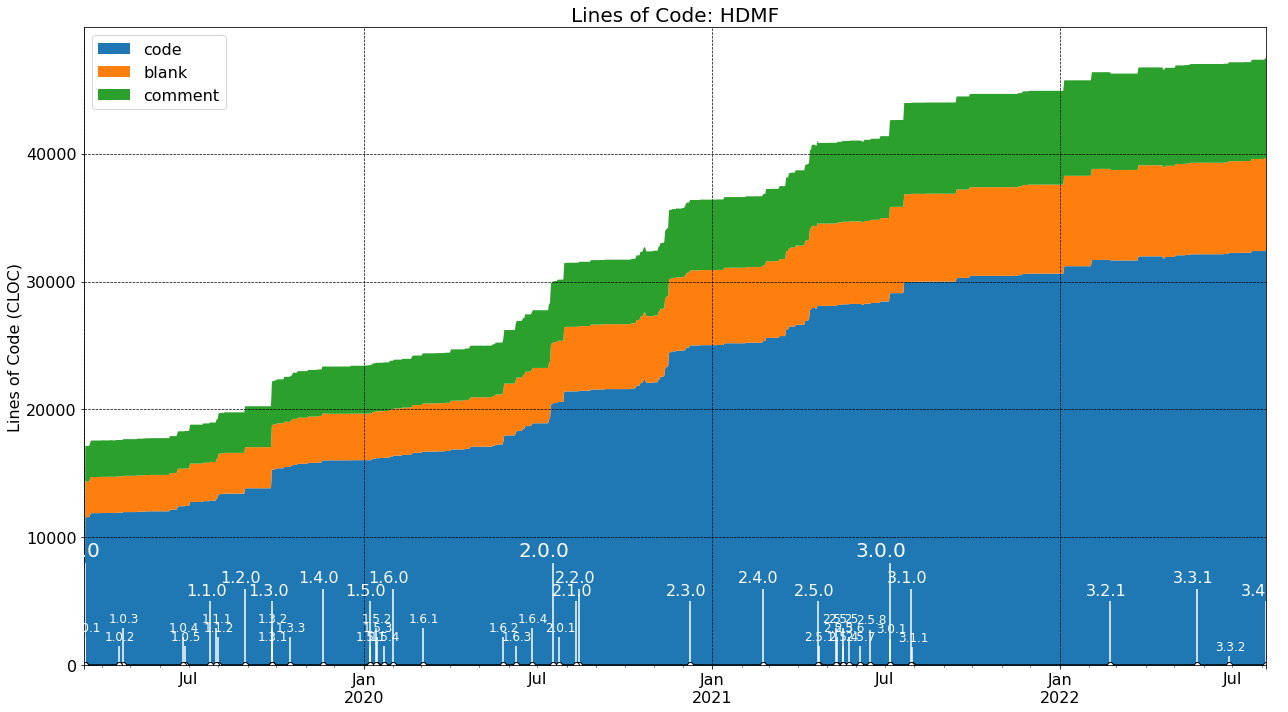

In [8]:
if git_code_stats:
    k = 'HDMF'
    curr_df = pd.DataFrame.from_dict({'code': code_summary_stats['codes'][k], 
                                      'blank': code_summary_stats['blanks'][k], 
                                      'comment': code_summary_stats['comments'][k]})
    curr_df.index = date_range
    ax = curr_df.plot.area(
        figsize=(18,10), 
        stacked=True, 
        linewidth=0, 
        fontsize=16)
    
    # Choose some nice levels
    names, dates = git_repo_infos[k].get_release_names_and_dates()
    version_jumps = GitHubRepoInfo.get_version_jump_from_tags(names)
    levels = []
    curr_minor = 5000
    curr_patch = 700
    for n in names:
        if version_jumps[n] == "major":
            levels.append(8000)
        elif version_jumps[n] == "minor":
            levels.append(curr_minor)
            curr_minor += 1000
            if curr_minor > 6000:
                curr_minor = 5000
        else:
            levels.append(curr_patch)
            curr_patch += 700
            if curr_patch > 3000:
                curr_patch = 1500
    
    ax.vlines(dates, 0, levels, color="white")  # The vertical stems.
    ax.plot(dates, np.zeros_like(dates), "-o",
            color="k", markerfacecolor="w")  # Baseline and markers on it.
    # annotate lines
    for d, l, r in zip(dates, levels, names):
        ax.annotate(r, xy=(d, l),
                    xytext=(14+2, np.sign(l)*3), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top",
                    fontsize=20 if version_jumps[r] == "major" else 16 if version_jumps[r] == "minor" else 12,
                    color='white')

    plt.legend(loc=2, prop={'size': 16})
    plt.ylabel('Lines of Code (CLOC)', fontsize=16)
    plt.grid(color='black', linestyle='--', linewidth=0.7, axis='both')
    plt.title("Lines of Code: %s" % k, fontsize=20)
    plt.tight_layout()
    plt.show()
